# Load Preprocessed Data

In [1]:
import os
import pickle
import pandas as pd

import matplotlib.pyplot as plt

from config import RAW_DIR, PRE_DIR, RES_DIR
from utils.data_porter import read_from_csv, save_to_csv

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 

In [2]:
with open(os.path.join(PRE_DIR, 'train_data.pkl'), 'rb') as f:
    train_data = pickle.load(f)
train_data.head()

with open(os.path.join(PRE_DIR, 'test_data.pkl'), 'rb') as f:
    test_data = pickle.load(f)
test_data.head()

,overall,asin,reviewTime,reviewerID,reviewerName,reviewText,summary,num_review_ps,num_review_gm
0,5.0,B0000296O5,1999-10-14,A2AXQTB83VMK4L,Amazon Customer,I'm having the most fun I've ever had on PlayS...,Best RPG Ever!,6,268
1,4.0,B00002NDRY,1999-11-05,A2T04VAIXSKJH2,Stefan,I'm usually not crazy about real-time strategy...,Good real time strategy game,6,67
2,5.0,B000021Y5F,1999-11-10,A1QA8K3LD9K892,Chris Adamson,Williams made games for hard-core arcade gamer...,A cool 80's artifact,23,7
3,4.0,B00000JL6V,1999-11-10,AMGJMFJ63DWWH,Ed Matuskey,"Once again you put your hand to the book, and ...","Beautiful game, with excellent (and hard!) puz...",5,37
4,5.0,B00000K4AX,1999-11-10,A3VWWQT4XDSBGQ,Joshua W. Fenton,"If you loved Half-Life, this is a must buy. I ...",AWESOME!,5,26


,overall,asin,reviewTime,reviewerID,reviewerName,reviewText,summary,num_review_ps,num_review_gm
424371,3.0,B00L59D9HG,2017-01-16,A1JO2IPCY1J4PS,Honest Frizz,No problem at all with the charger itself. It...,You have to buy it Separately,5,390
424372,5.0,B00005ATSN,2017-01-16,ANVJU2ROVJC8A,Jemi Linked,Great game!,LOZ forever!,9,38
424373,5.0,B015OYM10I,2017-01-16,A19K4H7U79QKE0,Rafael Quintero,Awesome!,Five Stars,11,45
424374,5.0,B00Y4S5KPY,2017-01-16,A11JVJHDF59HJC,Hammerton,Son loves it and works with other razer color ...,Five Stars,7,119
424375,1.0,B00O4FOB3O,2017-01-16,A1JXGU255ZN7JJ,MasterBlaster,I'm updating my review after having used these...,great to start but...,8,31


In [3]:
train_data.shape
val_data = train_data.iloc[int(train_data.shape[0]*0.9):]
val_data.shape
train_data = train_data.iloc[:int(train_data.shape[0]*0.9)]
train_data.shape

(424371, 9)

(42438, 9)

(381933, 9)

In [4]:
# Select only the three columns of user-item ids and ratings
# for collaborative filtering recommendation
train_rate = train_data[['asin', 'reviewerID', 'overall']]
val_rate = val_data[['asin', 'reviewerID', 'overall']]
test_rate = test_data[['asin', 'reviewerID', 'overall']]

# Try different model

In [5]:
from surprise import SVD
from surprise import accuracy
from surprise import Reader
from surprise.model_selection import GridSearchCV
from surprise import Dataset
from surprise import BaselineOnly
from surprise import KNNBaseline

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as mae

In [6]:
# load train validation data set
reader = Reader(rating_scale = (0.0, 5.0))
train_set = Dataset.load_from_df(train_rate, reader).build_full_trainset()
val_set = Dataset.load_from_df(val_rate, reader).build_full_trainset().build_testset()
test_set = Dataset.load_from_df(test_rate, reader).build_full_trainset().build_testset()

In [7]:
# output model evaluation metrics mae，mse
def print_metrics_sp(predictions):
    mae_score = accuracy.mae(predictions)
    mse_score = accuracy.mse(predictions)
    return mae_score, mse_score

## BaselineOnly

In [8]:
new_train_rate = pd.concat([train_rate, val_rate])
new_train_set = Dataset.load_from_df(new_train_rate, reader).build_full_trainset()

In [9]:
new_train_rate.head()

,asin,reviewerID,overall
0,B0000296O5,A2AXQTB83VMK4L,5.0
1,B00002NDRY,A2T04VAIXSKJH2,4.0
2,B000021Y5F,A1QA8K3LD9K892,5.0
3,B00000JL6V,AMGJMFJ63DWWH,4.0
4,B00000K4AX,A3VWWQT4XDSBGQ,5.0


In [10]:
# Ensure the model can run

bsl_options = {
    'method': 'als',
    'n_factors':200, 
    'n_epochs':30,
    'lr_all':0.005,
    'reg_all':0.1
}
bias_baseline = BaselineOnly(bsl_options)
bias_baseline.fit(new_train_set)
predictions = bias_baseline.test(test_set)

_, _ = print_metrics_sp(predictions)

Estimating biases using als...


MAE:  0.8497
MSE: 1.2221


In [25]:
# Set the hyperparameter list for grid search method tuning
# Use the performance on the validation set to select the optimal parameters

n_factors_lst = [10, 20, 50]
reg_all_lst =  [0.1, 0.3,0.5] # the regularization term for all parameters

res_df = {'para': [], 'mae': [], 'mse': []}
for factor in n_factors_lst:
    for reg in reg_all_lst:
        print(f'Fitting factor: {factor}, reg:{reg}')
        res_df['para'].append(f"{factor},{reg}")
        bsl_options = {
            'method': 'als',
            'n_factors': factor, 
            'n_epochs': 30,
            'lr_all': 0.005,
            'reg_all': reg}
        bias_baseline = BaselineOnly(bsl_options)
        bias_baseline.fit(train_set)
        predictions = bias_baseline.test(val_set)
        res_df['mae'].append(accuracy.mae(predictions))
        res_df['mse'].append(accuracy.mse(predictions))

Fitting factor: 10, reg:0.1
Estimating biases using als...


MAE:  0.8451
MSE: 1.1939
Fitting factor: 10, reg:0.3
Estimating biases using als...


MAE:  0.8451
MSE: 1.1939
Fitting factor: 10, reg:0.5
Estimating biases using als...


MAE:  0.8451
MSE: 1.1939
Fitting factor: 20, reg:0.1
Estimating biases using als...


MAE:  0.8451
MSE: 1.1939
Fitting factor: 20, reg:0.3
Estimating biases using als...


MAE:  0.8451
MSE: 1.1939
Fitting factor: 20, reg:0.5
Estimating biases using als...


MAE:  0.8451
MSE: 1.1939
Fitting factor: 50, reg:0.1
Estimating biases using als...


MAE:  0.8451
MSE: 1.1939
Fitting factor: 50, reg:0.3
Estimating biases using als...


MAE:  0.8451
MSE: 1.1939
Fitting factor: 50, reg:0.5
Estimating biases using als...


MAE:  0.8451
MSE: 1.1939


In [26]:
# print the results for all parameters
res_df = pd.DataFrame(res_df)
res_df

,para,mae,mse
0,"10,0.1",0.84506,1.193916
1,"10,0.3",0.84506,1.193916
2,"10,0.5",0.84506,1.193916
3,"20,0.1",0.84506,1.193916
4,"20,0.3",0.84506,1.193916
5,"20,0.5",0.84506,1.193916
6,"50,0.1",0.84506,1.193916
7,"50,0.3",0.84506,1.193916
8,"50,0.5",0.84506,1.193916


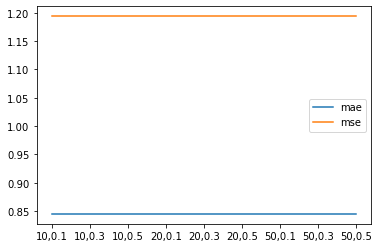

In [27]:
plt.plot(res_df['para'], res_df['mae'], label='mae')
plt.plot(res_df['para'], res_df['mse'], label='mse')
plt.legend()

The choice of parameters hardly affects the performance of the baseline model

In [64]:
# Test set (90% of data involved in training)

bsl_options = {
    'method': 'als',
    'n_factors':200, 
    'n_epochs':30,
    'lr_all':0.005,
    'reg_all':0.1
}
bias_baseline = BaselineOnly(bsl_options)
bias_baseline.fit(new_train_set)
predictions = bias_baseline.test(test_set)

_, _ = print_metrics_sp(predictions)

Estimating biases using als...


MAE:  0.8497
MSE: 1.2221


In [71]:
# Test set (80% of data involved in training)

bsl_options = {
    'method': 'als',
    'n_factors':200, 
    'n_epochs':30,
    'lr_all':0.005,
    'reg_all':0.1
}
bias_baseline = BaselineOnly(bsl_options)
bias_baseline.fit(train_set)
predictions = bias_baseline.test(test_set)

_, _ = print_metrics_sp(predictions)

Estimating biases using als...


MAE:  0.8748
MSE: 1.2609


Through the experiment, we can generally find that the more training data involved, the better the model performance.

## Biased SGD model

In [29]:
bias_sgd = SVD(n_factors=200, n_epochs=30, lr_all=0.005, reg_all=0.02)
bias_sgd.fit(new_train_set)
predictions = bias_sgd.test(test_set)
print_metrics_sp(predictions)

MAE:  0.8419
MSE: 1.2388


(0.8419392576060248, 1.2387782765269668)

In [30]:
n_factors_lst = [10, 50, 100, 200]
reg_all_lst = [0.01, 0.02, 0.03, 0.05]

res_df = {'para': [], 'mae': [], 'mse': []}
for n in n_factors_lst:
    for reg_all in reg_all_lst:
        print(f'Fitting factor: {n}, reg:{reg_all}')
        res_df['para'].append(f"{n},{reg_all}")
        bias_sgd = SVD(n_factors=n, n_epochs=30, lr_all=0.005, reg_all=reg_all)
        bias_sgd.fit(train_set)
        predictions = bias_sgd.test(val_set)
        res_df['mae'].append(accuracy.mae(predictions))
        res_df['mse'].append(accuracy.mse(predictions))

Fitting factor: 10, reg:0.01


MAE:  0.8216
MSE: 1.1862
Fitting factor: 10, reg:0.02


MAE:  0.8226
MSE: 1.1862
Fitting factor: 10, reg:0.03


MAE:  0.8227
MSE: 1.1843
Fitting factor: 10, reg:0.05


MAE:  0.8232
MSE: 1.1822
Fitting factor: 50, reg:0.01


MAE:  0.8265
MSE: 1.1952
Fitting factor: 50, reg:0.02


MAE:  0.8261
MSE: 1.1928
Fitting factor: 50, reg:0.03


MAE:  0.8260
MSE: 1.1886
Fitting factor: 50, reg:0.05


MAE:  0.8265
MSE: 1.1866
Fitting factor: 100, reg:0.01


MAE:  0.8308
MSE: 1.2003
Fitting factor: 100, reg:0.02


MAE:  0.8307
MSE: 1.2008
Fitting factor: 100, reg:0.03


MAE:  0.8292
MSE: 1.1963
Fitting factor: 100, reg:0.05


MAE:  0.8290
MSE: 1.1900
Fitting factor: 200, reg:0.01


MAE:  0.8376
MSE: 1.2128
Fitting factor: 200, reg:0.02


MAE:  0.8370
MSE: 1.2086
Fitting factor: 200, reg:0.03


MAE:  0.8387
MSE: 1.2081
Fitting factor: 200, reg:0.05


MAE:  0.8352
MSE: 1.1986


In [42]:
# print the results for all parameters
# Because MSE has a large loss for outliers while MAE represents loss in an average sense
# we set MAE taking precedence in the ranking
res_df = pd.DataFrame(res_df)
res_df = res_df.sort_values(by=['mae', 'mse']).reset_index(drop=True)
res_df

,para,mae,mse
0,"10,0.01",0.821631,1.186248
1,"10,0.02",0.822572,1.186152
2,"10,0.03",0.822677,1.184347
3,"10,0.05",0.823190,1.182164
4,"50,0.03",0.825971,1.188587
5,"50,0.02",0.826106,1.192792
6,"50,0.01",0.826516,1.195176
7,"50,0.05",0.826520,1.186558
8,"100,0.05",0.829048,1.190026
9,"100,0.03",0.829188,1.196336


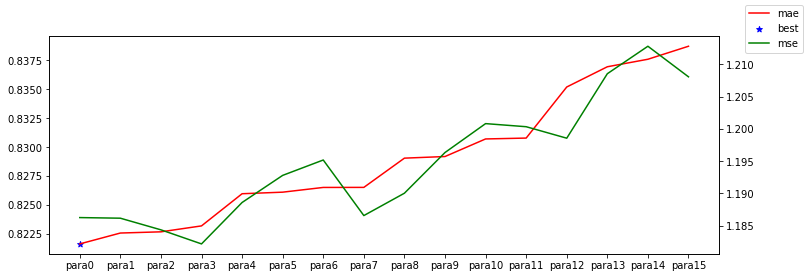

In [46]:
fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(111)
xtick = [f"para{i}" for i in range(len(res_df))]
ax1.plot(xtick, res_df['mae'], label='mae', color='r')
ax1.scatter(xtick[:1], res_df['mae'].tolist()[:1], marker='*', label='best', color='blue')
ax2 = ax1.twinx()
ax2.plot(xtick, res_df['mse'], label='mse', color='g')
fig.legend()

Marking out the optimal parameters:
- n = 10
- reg_all = 0.01

In [67]:
# Test set (90% of data involved in training)

bias_sgd = SVD(n_factors=10, n_epochs=30, lr_all=0.005, reg_all=0.01)
bias_sgd.fit(new_train_set)
predictions = bias_sgd.test(test_set)
print_metrics_sp(predictions)

MAE:  0.8290
MSE: 1.2214


(0.8290480470206647, 1.2213790113726917)

In [72]:
# Test set (80% of data involved in training)

bias_sgd = SVD(n_factors=10, n_epochs=30, lr_all=0.005, reg_all=0.01)
bias_sgd.fit(train_set)
predictions = bias_sgd.test(test_set)
print_metrics_sp(predictions)

MAE:  0.8568
MSE: 1.2599


(0.8568192156237626, 1.2599130011685071)

## KNNBasic

In [47]:
knn_model = KNNBaseline(k=40, min_k=1)
knn_model.fit(new_train_set)
predictions = knn_model.test(test_set)
print_metrics_sp(predictions)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.


MAE:  0.8447
MSE: 1.3351


(0.8446775544982594, 1.3351487067036343)

In [50]:
k_lst = [50, 100, 200, 300]
min_k_lst = [1, 2, 3, 10]

res_df = {'para': [], 'mae': [], 'mse': []}
for k in k_lst:
    for min_k in min_k_lst:
        print(f'Fitting factor: {k}, reg:{min_k}')
        res_df['para'].append(f"{k},{min_k}")
        knn_model = KNNBaseline(k=k, min_k=min_k)
        bias_sgd.fit(train_set)
        predictions = bias_sgd.test(val_set)
        res_df['mae'].append(accuracy.mae(predictions))
        res_df['mse'].append(accuracy.mse(predictions))

Fitting factor: 50, reg:1


MAE:  0.8354
MSE: 1.1997
Fitting factor: 50, reg:2


MAE:  0.8344
MSE: 1.1983
Fitting factor: 50, reg:3


MAE:  0.8357
MSE: 1.2008
Fitting factor: 50, reg:10


MAE:  0.8350
MSE: 1.1985
Fitting factor: 100, reg:1


MAE:  0.8358
MSE: 1.1993
Fitting factor: 100, reg:2


MAE:  0.8348
MSE: 1.1986
Fitting factor: 100, reg:3


MAE:  0.8359
MSE: 1.1985
Fitting factor: 100, reg:10


MAE:  0.8348
MSE: 1.1982
Fitting factor: 200, reg:1


MAE:  0.8351
MSE: 1.1973
Fitting factor: 200, reg:2


MAE:  0.8349
MSE: 1.1983
Fitting factor: 200, reg:3


MAE:  0.8351
MSE: 1.1973
Fitting factor: 200, reg:10


MAE:  0.8354
MSE: 1.1984
Fitting factor: 300, reg:1


MAE:  0.8350
MSE: 1.1977
Fitting factor: 300, reg:2


MAE:  0.8354
MSE: 1.1989
Fitting factor: 300, reg:3


MAE:  0.8356
MSE: 1.1980
Fitting factor: 300, reg:10


MAE:  0.8353
MSE: 1.1995


In [51]:
res_df = pd.DataFrame(res_df)
res_df = res_df.sort_values(by=['mae', 'mse']).reset_index(drop=True)
res_df

,para,mae,mse
0,"50,2",0.834428,1.198282
1,"100,2",0.834839,1.198560
2,"100,10",0.834841,1.198160
3,"200,2",0.834881,1.198294
4,"50,10",0.834953,1.198495
5,"300,1",0.835049,1.197721
6,"200,1",0.835081,1.197317
7,"200,3",0.835127,1.197259
8,"300,10",0.835300,1.199509
9,"50,1",0.835386,1.199700


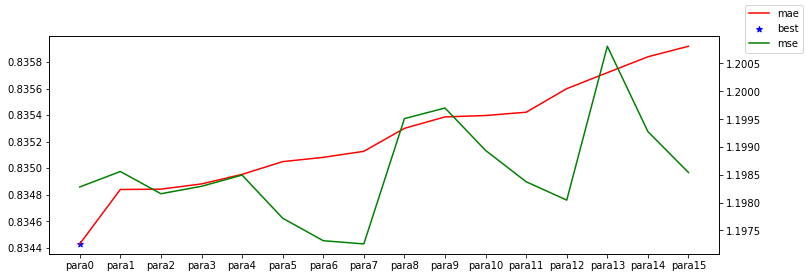

In [52]:
# The volatility on the graph may be due to the model being more sensitive to one of the parameters
# Find the generally optimal parameter
fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(111)
xtick = [f"para{i}" for i in range(len(res_df))]
ax1.plot(xtick, res_df['mae'], label='mae', color='r')
ax1.scatter(xtick[:1], res_df['mae'].tolist()[:1], marker='*', label='best', color='blue')
ax2 = ax1.twinx()
ax2.plot(xtick, res_df['mse'], label='mse', color='g')
fig.legend()

Marking out the optimal parameters:
- k = 50
- min_k = 2

In [70]:
# Test set (90% of data involved in training)

knn_model = KNNBaseline(k=50, min_k=2)
knn_model.fit(new_train_set)
predictions = knn_model.test(test_set)
print_metrics_sp(predictions)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.


MAE:  0.8421
MSE: 1.2509


(0.8421157020089943, 1.2508704827986867)

In [73]:
# Test set (80% of data involved in training)

knn_model = KNNBaseline(k=50, min_k=2)
knn_model.fit(train_set)
predictions = knn_model.test(test_set)
print_metrics_sp(predictions)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.


MAE:  0.8710
MSE: 1.2771


(0.8710449280134849, 1.277050694812694)